In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, Adamax
from utils import SplitConformal, PCP_Classifcation
from tqdm import tqdm

count = 50
num_ = 200
alpha= 0.1
state = 123456
tf.keras.utils.set_random_seed(state)
tf.random.set_seed(state)
np.random.seed(state)
df=pd.read_csv('datasets/hmnist_28_28_RGB.csv')
Y_0 = df['label']
X_0 = df.drop(columns=['label'])

# Sample splitting
X_0, X_test, Y_0, Y_test = train_test_split(X_0, Y_0, test_size=0.5,random_state=state)
X_train, X_val, Y_train, Y_val = train_test_split(X_0, Y_0, test_size=0.5,random_state=state)

columns=list(X_train)

X_train=np.array(X_train, dtype=np.uint8).reshape(-1,28,28,3)
X_val=np.array(X_val, dtype=np.uint8).reshape(-1,28,28,3)
X_test=np.array(X_test, dtype=np.uint8).reshape(-1,28,28,3)

Y_train = Y_train.values
n_val = X_val.shape[0]
n_test = X_test.shape[0]
Y_val = Y_val.values
Y_test = Y_test.values

In [ ]:
def get_model():
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    model = Sequential()
    model.add(keras.layers.Input(shape=[28, 28, 3]))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
    
    return model



model = KerasClassifier(
    get_model,
    optimizer=Adamax(learning_rate= 0.001),
   loss='categorical_crossentropy'
)


model.fit(X_train, Y_train, epochs=30, batch_size=100,verbose=0)

In [ ]:
# Construct the prediction sets of SCP
SCP = SplitConformal(X_val, Y_val, model, alpha, random_state=state, allow_empty= True)
Set = SCP.predict(X_test)

# Store the prediction set size of SCP
size_scp = np.array([len(Set[i]) for i in range(n_test)])

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

prob_cv = np.zeros((np.shape(X_train)[0],max(Y_train)+1))

for train_index_cv, test_index_cv in tqdm(kf.split(X_train), total=kf.get_n_splits(X_train)):

    model_cv = KerasClassifier(
        get_model,
        optimizer=Adamax(learning_rate= 0.001),
       loss='categorical_crossentropy'
    )
    
    model_cv.fit(X_train[train_index_cv], Y_train[train_index_cv], epochs=30, batch_size=100,verbose=0)
    prob_cv[test_index_cv] = model_cv.predict_proba(X_train[test_index_cv])

In [141]:
prob_v_0 = model.predict_proba(X_val)
prob_t_0 = model.predict_proba(X_test)

PCP_model = PCP_Classifcation(prob_cv)
set_pcp, cover_pcp, size_pcp, p_pcp = PCP_model.calibrate(prob_v_0, prob_t_0, Y_val, Y_test)

157/157 [==============================] - 2s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5008/5008 [00:10<00:00, 457.81it/s]


In [142]:
# Compute the local average set size of SCP
prob_top = np.max(prob_t_0,1)
order = np.argsort(np.max(prob_t_0,1))
prob_top = prob_top[order]
size_0_sorted = np.array(size_scp)[order]
rate_size_scp = [] 

grids_0 =  np.linspace(min(prob_top), max(prob_top),count)
for prob_t_j in grids_0:
    
    distance = abs(prob_top - prob_t_j)
    sort_index = np.argsort(distance)[:num_]
    rate_size_scp.append([np.mean(size_0_sorted[sort_index]),np.std(size_0_sorted[sort_index])])

In [143]:
# Compute the local average coverage rate and set size of PCP
order = np.argsort(p_pcp)
cover_t_sorted = np.array(cover_pcp)[order]
size_t_sorted = np.array(size_pcp)[order]
p_pcp = np.array(p_pcp)[order]


grids_1 =  np.linspace(min(p_pcp), max(p_pcp),count)

rate_pcp = []
rate_size_pcp = []

for prob_t_j in grids_1:
    
    distance = abs(p_pcp - prob_t_j)
    sort_index = np.argsort(distance)[:num_]
    rate_pcp.append(np.mean(cover_t_sorted[sort_index]))
    rate_size_pcp.append([np.mean(size_t_sorted[sort_index]),np.std(size_t_sorted[sort_index])])


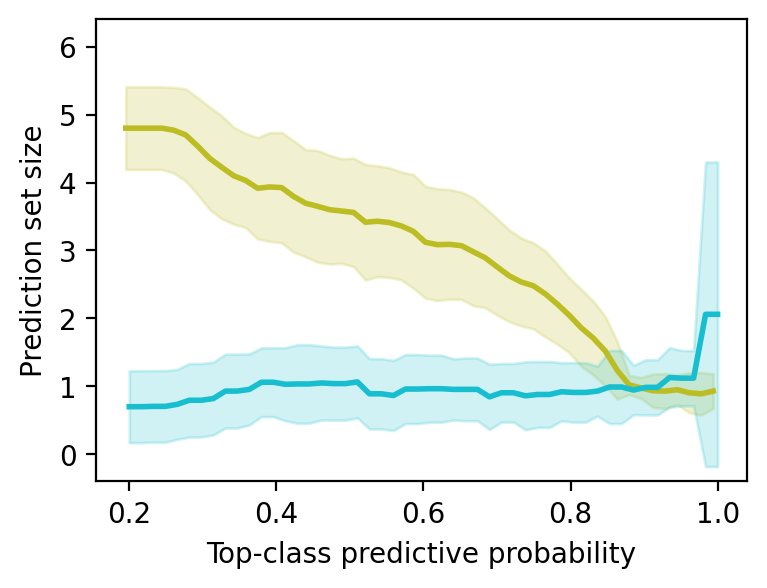

In [144]:
# Plot the local average set size of SCP and PCP
rate_size_scp = np.array(rate_size_scp)
rate_size_pcp = np.array(rate_size_pcp)


plt.figure(figsize=(4.2, 3), dpi=200)
plt.plot(grids_0, rate_size_scp[:,0],label='SCP',color='tab:olive',linewidth=2)

plt.fill_between(grids_0, rate_size_scp[:,0] - rate_size_scp[:,1],rate_size_scp[:,0] + rate_size_scp[:,1],
                 color='tab:olive', alpha=0.2)

plt.plot(grids_1, rate_size_pcp[:,0],label='PCP',color='tab:cyan',linewidth=2)


plt.fill_between(grids_1, rate_size_pcp[:,0] - rate_size_pcp[:,1],rate_size_pcp[:,0] + rate_size_pcp[:,1],
                 color='tab:cyan', alpha=0.2)

plt.ylim([-0.4,6.4])
plt.ylabel('Prediction set size',fontsize=10)
plt.xlabel('Top-class predictive probability',fontsize=10)

In [145]:
# Compute the local average accuracy of the baseline classifier
prob_top = np.max(prob_t_0,1)
pred_top = np.argmax(prob_t_0,1)
order = np.argsort(prob_top)
prob_top = prob_top[order]
pred_top = pred_top[order]
cover_top = Y_test[order] == pred_top

grids_2 =  np.linspace(min(prob_top), max(prob_top),count)

rate_acc = []

for prob_t_j in grids_2:
    
    distance = abs(prob_top - prob_t_j)
    sort_index = np.argsort(distance)[:num_]
    rate_acc.append(np.mean(cover_top[sort_index]))

In [146]:
# Compute the local average accuracy of the classifier calibrated by isotonic regression
from sklearn.calibration import CalibratedClassifierCV
model_c = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
model_c.fit(X_val, Y_val)
probabilities = model_c.predict_proba(X_test)

prob_top = np.max(probabilities,1)
pred_top = np.argmax(probabilities,1)
order = np.argsort(prob_top)
prob_top = prob_top[order]
pred_top = pred_top[order]
cover_top = Y_test[order] == pred_top
grids_3 =  np.linspace(min(prob_top), max(prob_top),count)

rate_cal = []

for prob_t_j in grids_3:
    
    distance = abs(prob_top - prob_t_j)
    sort_index = np.argsort(distance)[:num_]
    rate_cal.append(np.mean(cover_top[sort_index]))

157/157 [==============================] - 2s 11ms/step


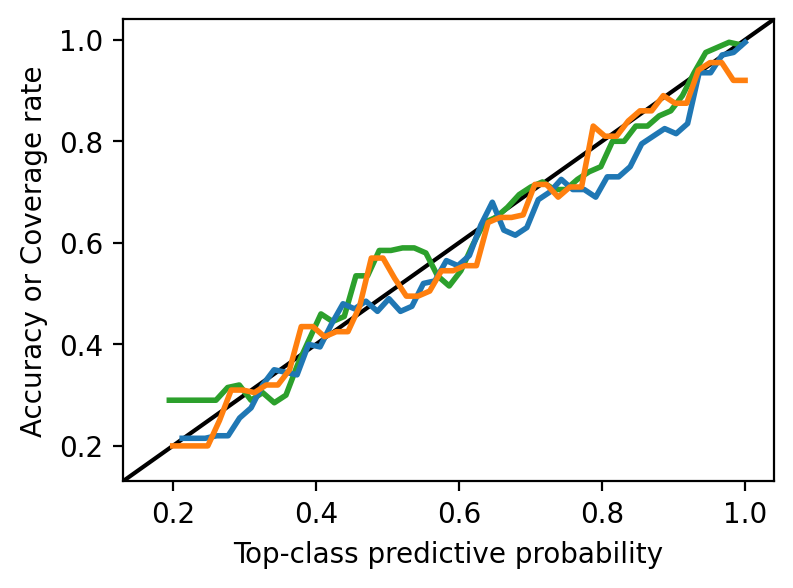

In [147]:
# Plot the local average accuracy and coverage rate
plt.figure(figsize=(4.2, 3), dpi=200)
x = np.linspace(0.0, 2, 200) 
y = x
plt.plot(x, y,'black')
plt.plot(grids_2,rate_acc,label='Baseline',color='tab:green',linewidth=2)
plt.plot(grids_3,rate_cal,label='Isotonic',linewidth=2)
plt.plot(grids_1,rate_pcp,label='PCP',linewidth=2)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim((0.13, 1.04))
plt.ylim((0.13, 1.04))
plt.ylabel('Accuracy or Coverage rate',fontsize=10)
plt.xlabel('Top-class predictive probability',fontsize=10)